# Network Builder

## Description
Build the semantic network from clean Reddit posts' and comments.

## Setup

### Libraries (Pyhton)

In [1]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*n_jobs value 1 overridden.*")

In [2]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import csr_matrix
import sys
import time
import umap

### Directories

In [3]:
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    BASE_DIR = Path().resolve()

SRC_DIR = BASE_DIR / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

DATA_DIR = BASE_DIR / 'data'
DATA_DIR.mkdir(exist_ok=True)
POSTS_DIR = DATA_DIR / 'posts'
POSTS_ALL_DIR = POSTS_DIR / 'all'
POSTS_FILTERED_DIR = POSTS_DIR / 'filtered'
POSTS_FILTERED_CLEAN_DIR = POSTS_FILTERED_DIR / 'clean'
COMMENTS_DIR = DATA_DIR / 'comments'
COMMENTS_CLEAN_DIR = COMMENTS_DIR / 'clean'
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_GRAPHS_DIR = RESULTS_DIR / 'graphs'

### Libraries (Custom)

In [4]:
from importlib import reload

In [5]:
import builder_sparse as bns
import ncp
import utils

In [164]:
reload(bns)

<module 'builder_sparse' from 'C:\\Backup\\000_DS\\courses\\00-network-science\\ns-project\\src\\builder_sparse.py'>

## Import Data

In [6]:
filename_posts = POSTS_FILTERED_CLEAN_DIR / 'all_posts_clean.json'
filename_comments = COMMENTS_CLEAN_DIR / 'all_comments_clean.json'
posts = pd.read_json(filename_posts)
comments = pd.read_json(filename_comments)

## Build Bipartite Network

In [7]:
# --- Prep posts ---
df_posts = posts.copy()
df_posts['document_id'] = df_posts['id']
df_posts['root_post_id'] = df_posts['id']
df_posts['document_type'] = 'post'

# --- Prep comments ---
df_comments = comments.copy()
df_comments['document_id'] = df_comments['comment_id']
df_comments['root_post_id'] = df_comments['post_id']
df_comments['document_type'] = 'comment'

# --- Ensure the same columns exist in both ---
common_cols = list(set(df_posts.columns).intersection(set(df_comments.columns)))
df_merged = pd.concat([df_posts[common_cols], df_comments[common_cols]], ignore_index=True)

In [ ]:
# df_merged.to_json(DATA_DIR / 'data.json', orient='records', lines=True)

In [8]:
network_sparse = bns.BuildNetwork(df_merged, column='filtered_pos')
network_sparse.build(tfidf=True)

In [9]:
network_bipartite_sparse = bns.to_igraph_bipartite(network_sparse, use='Pwd')
print(f"Bipartite graph has {network_bipartite_sparse.vcount()} nodes and {network_bipartite_sparse.ecount()} edges.")

Bipartite graph has 24588 nodes and 403574 edges.


### Analyze Degree Distribution

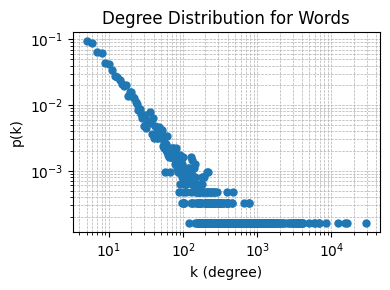

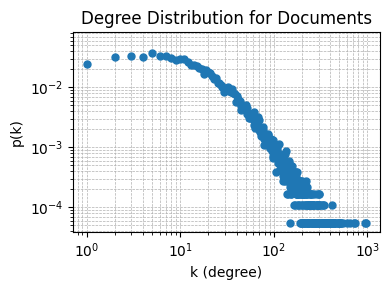

In [8]:
network_sparse.plot_degree_distribution(type='words')
network_sparse.plot_degree_distribution(type='documents')

--- Power-Law Analysis (words) ---
Gamma (scaling exponent): 2.0085
K_min (cutoff): 112.0


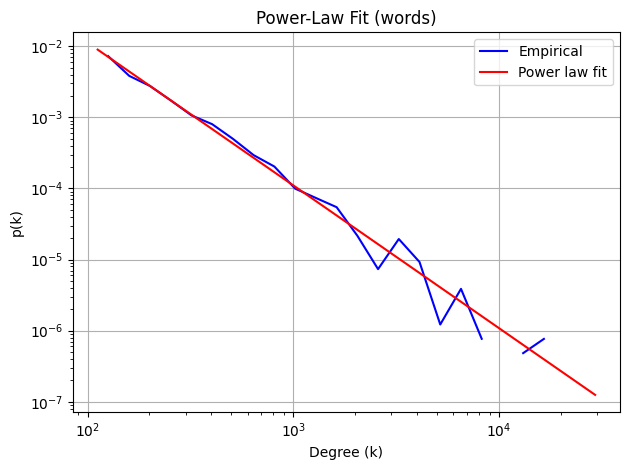

--- Power-Law Analysis (documents) ---
Gamma (scaling exponent): 3.9045
K_min (cutoff): 183.0


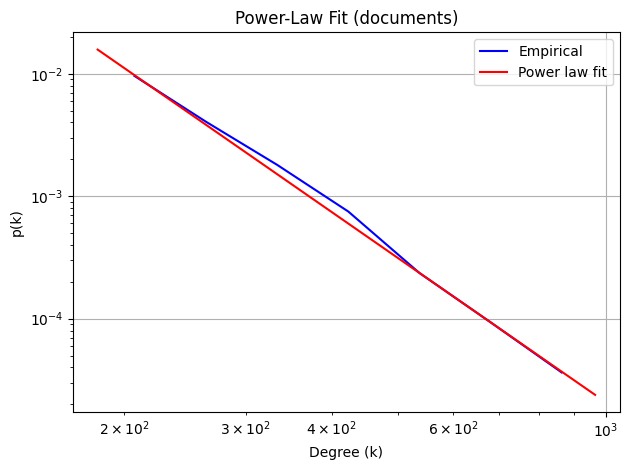

In [9]:
network_sparse.analyze_degree_distribution_powerlaw(type='words')
network_sparse.analyze_degree_distribution_powerlaw(type='documents')

## Build Projected Networks
Project the bipartite network onto words and documents.

### Word Projection

#### Network Community Profile
Use Local PageRank to calculate and plot the NCP.

In [8]:
word_projection_sparse = bns.to_igraph_projected(network_sparse, use='Pww', threshold=0.0)
print(f"Word-projected graph has {word_projection_sparse.vcount()} nodes and {word_projection_sparse.ecount()} edges.")

Word-projected graph has 6247 nodes and 2628289 edges.


In [9]:
# Create thresholded graphs
word_proj_90 = ncp.threshold_graph(word_projection_sparse, 90)
word_proj_95 = ncp.threshold_graph(word_projection_sparse, 95)
word_proj_99 = ncp.threshold_graph(word_projection_sparse, 99)

In [10]:
sizes = list(range(10, 1001, 50))
num_seeds = 10

In [11]:
# 90th percentile
start_time = time.time()
ncp_90 = ncp.compute_ncp(word_proj_90, sizes, num_seeds=num_seeds)
end_time = time.time()

print(f"NCP computed for {len(sizes)} sizes with {num_seeds} seeds in {end_time - start_time:.2f} seconds.")

Size 10: best conductance = 0.8237
Size 60: best conductance = 0.5792
Size 110: best conductance = 0.6775
Size 160: best conductance = 0.7804
Size 210: best conductance = 0.8001
Size 260: best conductance = 0.8570
Size 310: best conductance = 0.8803
Size 360: best conductance = 0.8974
Size 410: best conductance = 0.9018
Size 460: best conductance = 0.9119
Size 510: best conductance = 0.9144
Size 560: best conductance = 0.9215
Size 610: best conductance = 0.9243
Size 660: best conductance = 0.9267
Size 710: best conductance = 0.9295
Size 760: best conductance = 0.9316
Size 810: best conductance = 0.9335
Size 860: best conductance = 0.9344
Size 910: best conductance = 0.9369
Size 960: best conductance = 0.9400
NCP computed for 20 sizes with 10 seeds in 50.54 seconds.


In [12]:
# 95th percentile
start_time = time.time()
ncp_95 = ncp.compute_ncp(word_proj_95, sizes, num_seeds=num_seeds)
end_time = time.time()

print(f"NCP computed for {len(sizes)} sizes with {num_seeds} seeds in {end_time - start_time:.2f} seconds.")

Size 10: best conductance = 0.8200
Size 60: best conductance = 0.6018
Size 110: best conductance = 0.8088
Size 160: best conductance = 0.8755
Size 210: best conductance = 0.9032
Size 260: best conductance = 0.8914
Size 310: best conductance = 0.8864
Size 360: best conductance = 0.8811
Size 410: best conductance = 0.9495
Size 460: best conductance = 0.9531
Size 510: best conductance = 0.8676
Size 560: best conductance = 0.8484
Size 610: best conductance = 0.9581
Size 660: best conductance = 0.8163
Size 710: best conductance = 0.7505
Size 760: best conductance = 0.7443
Size 810: best conductance = 0.7371
Size 860: best conductance = 0.9623
Size 910: best conductance = 0.9625
Size 960: best conductance = 0.7196
NCP computed for 20 sizes with 10 seeds in 22.42 seconds.


In [13]:
# 99th percentile
start_time = time.time()
ncp_99 = ncp.compute_ncp(word_proj_99, sizes, num_seeds=num_seeds)
end_time = time.time()

print(f"NCP computed for {len(sizes)} sizes with {num_seeds} seeds in {end_time - start_time:.2f} seconds.")

Size 10: best conductance = 0.7992
Size 60: best conductance = 0.9027
Size 110: best conductance = 0.9414
Size 160: best conductance = 0.9136
Size 210: best conductance = 0.8918
Size 260: best conductance = 0.8792
Size 310: best conductance = 0.8745
Size 360: best conductance = 0.8696
Size 410: best conductance = 0.8691
Size 460: best conductance = 0.8657
Size 510: best conductance = 0.8574
Size 560: best conductance = 0.8362
Size 610: best conductance = 0.8329
Size 660: best conductance = 0.8013
Size 710: best conductance = 0.7249
Size 760: best conductance = 0.7195
Size 810: best conductance = 0.7121
Size 860: best conductance = 0.7056
Size 910: best conductance = 0.7030
Size 960: best conductance = 0.6966
NCP computed for 20 sizes with 10 seeds in 5.01 seconds.


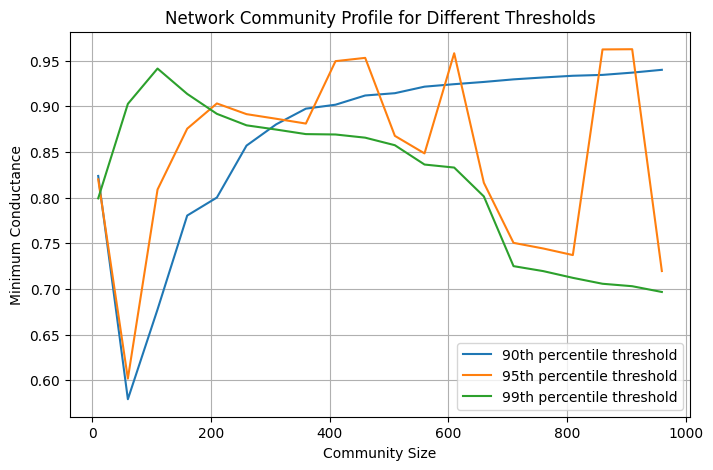

In [14]:
ncp_word_results = [ncp_90, ncp_95, ncp_99]
thresholds = [90, 95, 99]

ncp.plot_ncp(sizes, ncp_word_results, thresholds)

#### Build Network
Use 95th percentile threshold from NCP to build the WW graph.

In [18]:
print(f"Word-projected graph has {word_proj_95.vcount()} nodes and {word_proj_95.ecount()} edges.")
print(f"Graph is connected? {word_proj_95.is_connected()}.")

Word-projected graph has 6247 nodes and 131415 edges.
Graph is connected? False.


In [21]:
# Basic stats for full word-projected network
print("--- Word-Projected Network ---")
print(f"Average degree: {np.mean(word_proj_95.degree()):.2f}")
print(f"Median degree: {np.median(word_proj_95.degree()):.2f}")
print(f"Density: {word_proj_95.density():.5f}")
print(f"Diameter: {word_proj_95.diameter(directed=False, unconn=True):.2f}")
print(f"Average path length: {word_proj_95.average_path_length():.5f}")
components_word = word_proj_95.connected_components()
print(f"Connected components: {len(components_word)}\n")

# Largest component
giant_component_word = components_word.giant()
print("--- Giant Component of Word-Projected Network ---")
print(f"Size of the giant component: {giant_component_word.vcount()}")
print(f"Average degree: {np.mean(giant_component_word.degree()):.2f}")
print(f"Median degree: {np.median(giant_component_word.degree()):.2f}")
print(f"Density: {giant_component_word.density():.5f}")
print(f"Diameter: {giant_component_word.diameter(directed=False, unconn=False):.2f}")
print(f"Average path length: {giant_component_word.average_path_length():.5f}")

--- Word-Projected Network ---
Average degree: 42.07
Median degree: 6.00
Density: 0.00674
Diameter: 6.00
Average path length: 2.07978
Connected components: 404

--- Giant Component of Word-Projected Network ---
Size of the giant component: 5843
Average degree: 44.98
Median degree: 7.00
Density: 0.00770
Diameter: 6.00
Average path length: 2.07978


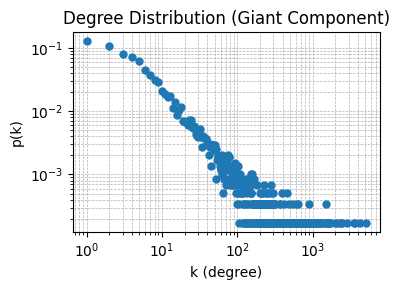

In [19]:
utils.plot_giant_component_degree_distribution(giant_component_word)

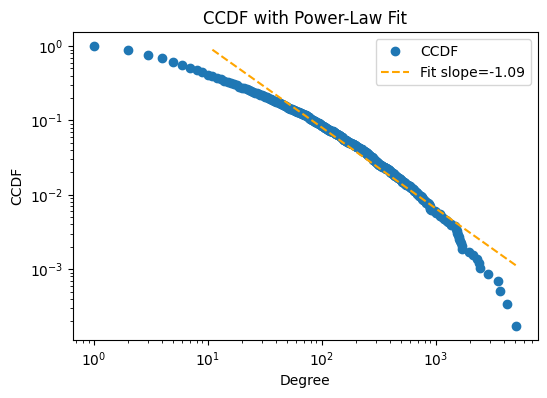

In [ ]:
utils.plot_ccdf(giant_component_word)

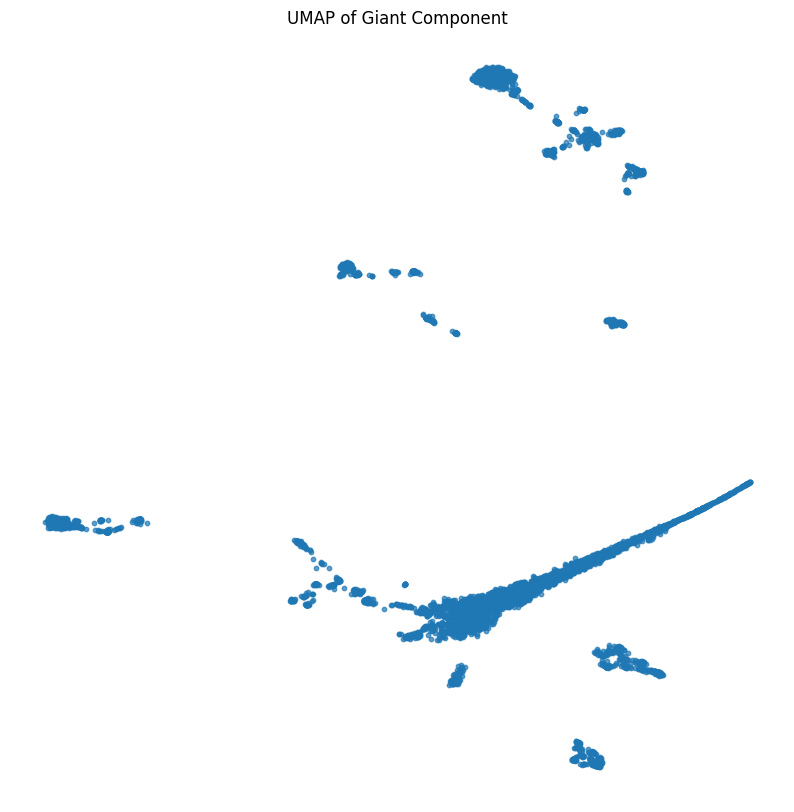

In [25]:
# Plot giant component
adj_matrix_giant_word = np.array(giant_component_word.get_adjacency().data, dtype=float)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(adj_matrix_giant_word)

plt.figure(figsize=(10, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1],
    s=10, alpha=0.7
    )
plt.title('UMAP of Giant Component')
plt.axis('off')
plt.show()

### Document Projection

#### Network Community Profile
Use Local PageRank to calculate and plot the NCP.

In [9]:
Pdd_thresholded = bns.filter_sparse_by_percentile(network_sparse.Pdd, percentile=99.0)

In [10]:
network_sparse.Pdd = Pdd_thresholded

In [11]:
docs_projection = bns.to_igraph_projected(network_sparse, use='Pdd', threshold=0.0)
print(f"Document-projected graph has {docs_projection.vcount()} nodes and {docs_projection.ecount()} edges.")

Document-projected graph has 18341 nodes and 924976 edges.


In [46]:
sizes = list(range(10, 5011, 100))
num_seeds = 5

In [47]:
# 95th percentile
start_time = time.time()
ncp_95_docs = ncp.compute_ncp(docs_projection, sizes, num_seeds=num_seeds, n_jobs=-1)
end_time = time.time()

print(f"NCP computed for {len(sizes)} sizes with {num_seeds} seeds in {end_time - start_time:.2f} seconds.")

Size 10: best conductance = 0.9916
Size 110: best conductance = 0.9313
Size 210: best conductance = 0.8871
Size 310: best conductance = 0.8479
Size 410: best conductance = 0.8020
Size 510: best conductance = 0.7653
Size 610: best conductance = 0.7328
Size 710: best conductance = 0.7220
Size 810: best conductance = 0.6713
Size 910: best conductance = 0.6431
Size 1010: best conductance = 0.6214
Size 1110: best conductance = 0.5947
Size 1210: best conductance = 0.5737
Size 1310: best conductance = 0.5505
Size 1410: best conductance = 0.5372
Size 1510: best conductance = 0.5148
Size 1610: best conductance = 0.4983
Size 1710: best conductance = 0.4780
Size 1810: best conductance = 0.4831
Size 1910: best conductance = 0.4859
Size 2010: best conductance = 0.4825
Size 2110: best conductance = 0.5048
Size 2210: best conductance = 0.5075
Size 2310: best conductance = 0.5106
Size 2410: best conductance = 0.5289
Size 2510: best conductance = 0.5358
Size 2610: best conductance = 0.5497
Size 2710: b

In [39]:
# 99th percentile
start_time = time.time()
ncp_99_docs = ncp.compute_ncp(docs_projection, sizes, num_seeds=num_seeds, n_jobs=-1)
end_time = time.time()

print(f"NCP computed for {len(sizes)} sizes with {num_seeds} seeds in {end_time - start_time:.2f} seconds.")

Size 10: best conductance = 0.9723
Size 110: best conductance = 0.8956
Size 210: best conductance = 0.8206
Size 310: best conductance = 0.7398
Size 410: best conductance = 0.6863
Size 510: best conductance = 0.6414
Size 610: best conductance = 0.5921
Size 710: best conductance = 0.5664
Size 810: best conductance = 0.5383
Size 910: best conductance = 0.5163
Size 1010: best conductance = 0.4958
Size 1110: best conductance = 0.4616
Size 1210: best conductance = 0.4582
Size 1310: best conductance = 0.4343
Size 1410: best conductance = 0.4119
Size 1510: best conductance = 0.4133
Size 1610: best conductance = 0.4258
Size 1710: best conductance = 0.4133
Size 1810: best conductance = 0.4342
Size 1910: best conductance = 0.4520
Size 2010: best conductance = 0.4634
Size 2110: best conductance = 0.4689
Size 2210: best conductance = 0.4711
Size 2310: best conductance = 0.4852
Size 2410: best conductance = 0.4906
Size 2510: best conductance = 0.4986
Size 2610: best conductance = 0.5075
Size 2710: b

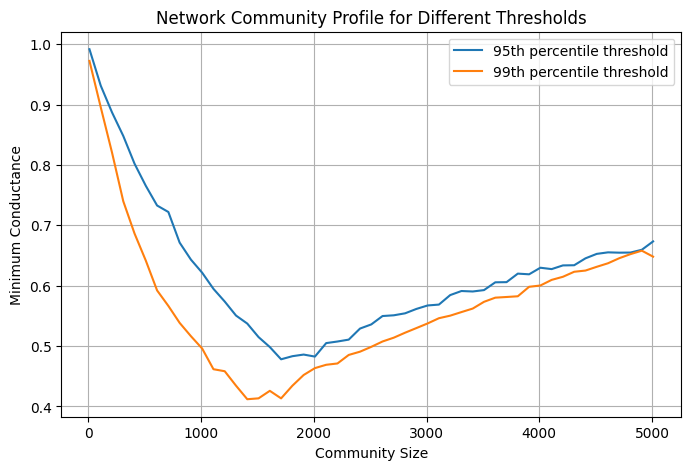

In [48]:
ncp_docs_results = [ncp_95_docs, ncp_99_docs]
thresholds = [95, 99]

ncp.plot_ncp(sizes, ncp_docs_results, thresholds)

#### Build Network
Use 99th percentile threshold from NCP to build the DD graph.

In [12]:
print(f"Word-projected graph has {docs_projection.vcount()} nodes and {docs_projection.ecount()} edges.")
print(f"Graph is connected? {docs_projection.is_connected()}.")

Word-projected graph has 18341 nodes and 924976 edges.
Graph is connected? False.


In [126]:
# Basic stats for full word-projected network
print("--- Document-Projected Network ---")
print(f"Average degree: {np.mean(docs_projection.degree()):.2f}")
print(f"Median degree: {np.median(docs_projection.degree()):.2f}")
print(f"Density: {docs_projection.density():.5f}")
print(f"Diameter: {docs_projection.diameter(directed=False, unconn=True):.2f}")
print(f"Average path length: {docs_projection.average_path_length():.5f}")
components_docs = docs_projection.connected_components()
print(f"Connected components: {len(components_docs)}\n")

# Largest component
giant_component_docs = components_docs.giant()
print("--- Giant Component of Document-Projected Network ---")
print(f"Size of the giant component: {giant_component_docs.vcount()}")
print(f"Average degree: {np.mean(giant_component_docs.degree()):.2f}")
print(f"Median degree: {np.median(giant_component_docs.degree()):.2f}")
print(f"Density: {giant_component_docs.density():.5f}")
print(f"Diameter: {giant_component_docs.diameter(directed=False, unconn=False):.2f}")
print(f"Average path length: {giant_component_docs.average_path_length():.5f}")

--- Document-Projected Network ---
Average degree: 100.86
Median degree: 39.00
Density: 0.00550
Diameter: 6.00
Average path length: 2.51146
Connected components: 2521

--- Giant Component of Document-Projected Network ---
Size of the giant component: 15819
Average degree: 116.94
Median degree: 50.00
Density: 0.00739
Diameter: 6.00
Average path length: 2.51146


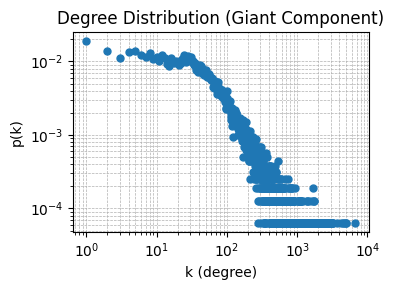

In [13]:
utils.plot_giant_component_degree_distribution(giant_component_docs)

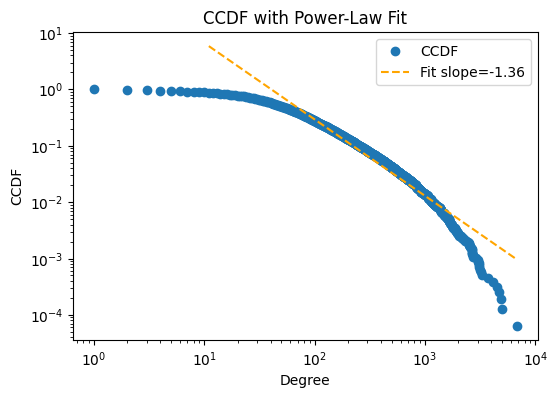

In [14]:
utils.plot_ccdf(giant_component_docs)

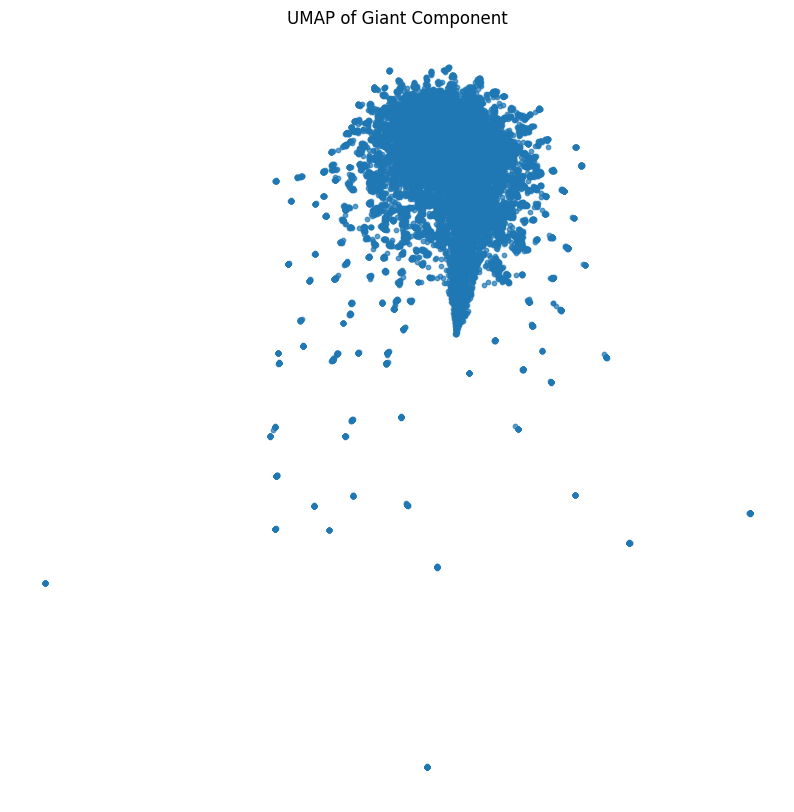

In [57]:
# Plot giant component
adj_matrix_giant_docs = np.array(giant_component_docs.get_adjacency().data, dtype=float)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(adj_matrix_giant_docs)

plt.figure(figsize=(10, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1],
    s=10, alpha=0.7
    )
plt.title('UMAP of Giant Component')
plt.axis('off')
plt.show()

#### Update Matrices and Pickle Export
Update BuildNetwork() matrices based on the documents in the giant component.

In [16]:
# Select documents
keep_docs = list(giant_component_docs.vs['name'])
keep_docs_indices = df_merged.index[df_merged['document_id'].isin(keep_docs)].tolist()

In [17]:
bns.filter_network_matrices_by_docs(network_sparse, keep_docs_indices)

In [21]:
filename_pickle_gdd = RESULTS_GRAPHS_DIR / 'g_dd.pickle'
network_sparse.pickle_export(filename_pickle_gdd, Pww=False)

## Save to .graphml

In [9]:
filename_b = RESULTS_GRAPHS_DIR / 'g_wd.graphml'
network_bipartite_sparse.write_graphml(str(filename_b))

In [ ]:
filename_w = RESULTS_GRAPHS_DIR / 'g_ww.graphml'
giant_component_word.write_graphml(str(filename_w))

In [56]:
filename_d = RESULTS_GRAPHS_DIR / 'g_dd.graphml'
giant_component_docs.write_graphml(str(filename_d))

## Clear Allocated Memory

In [165]:
# Run before exiting the program to clear memory
%reset -f
import gc
gc.collect()

0